### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population']

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                   PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.25)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-16 16:01:49.038 INFO     Building a set of 317255 households from which to build a population
2021-05-16 16:02:46.464 INFO     310928 households of mean size 2.55
2021-05-16 16:02:50.317 INFO     141192 buildings of mean size 5.62
2021-05-16 16:03:25.390 INFO     2036 classrooms of mean size 29.38
2021-05-16 16:03:25.752 INFO     131 care_homes of mean size 103.71
2021-05-16 16:03:26.762 INFO     92928 workplaces of mean size 5.62
2021-05-16 16:03:29.250 INFO     66.0% of workplaces closed by lockdown, leaving 33442 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-16 16:03:29.424 INFO     66.0% of classrooms closed by lockdown, leaving 724 open, of average Income Decile 4.32 (and st dev 3.04).
2021-05-16 16:03:29.462 INFO     Adding 345225 permanent contact groups
2021-05-16 16:03:29.463 INFO     Adding 0 ephemeral contact pairs
2021-05-16 16:03:30.407 INFO     Adding 239491 contacts each within one of the 141192 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid

kent_variant = Covid(name="B.1.1.7")
indian_variant = Covid(name="B.1.617.2")

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-16 16:04:01.888 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0180
2021-05-16 16:06:32.965 INFO     Day 30, prop infected is 0.14, prop infectious is 0.0227


### Run the simulation for January and February

2021-05-16 16:07:11.374 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0220
2021-05-16 16:11:00.390 INFO     Day 51, prop infected is 0.20, prop infectious is 0.0033
2021-05-16 16:11:30.873 INFO     Day 60, prop infected is 0.20, prop infectious is 0.0021
2021-05-16 16:11:32.494 INFO      Realized R0 of early infections is 0.96
2021-05-16 16:11:32.495 INFO      20.2 percent of the population was infected during the epidemic


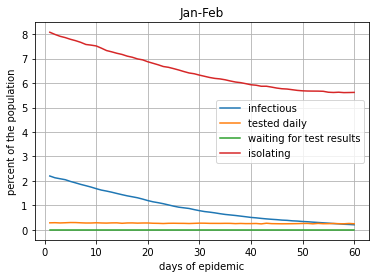

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 16:11:36.132 INFO     66.0% of workplaces closed by lockdown, leaving 33154 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-16 16:11:36.388 INFO     0.0% of classrooms closed by lockdown, leaving 1697 open, of average Income Decile 4.80 (and st dev 3.08).
2021-05-16 16:11:36.429 INFO     Adding 345910 permanent contact groups
2021-05-16 16:11:36.753 INFO     Adding 118970 ephemeral contact pairs
2021-05-16 16:11:37.689 INFO     Adding 239396 contacts each within one of the 141192 buildings (contact density of 0.75)


In [10]:
from codit.society.lateral import LateralFlowUK
lat_flow_soc = LateralFlowUK(config=SOCIETY_CFG)

2021-05-16 16:11:47.623 INFO     The city has 20x the number of lateral flow tests available, as PCRs


2021-05-16 16:12:28.042 INFO     Setting mass testing valency/degree limit to 22
2021-05-16 16:12:36.335 INFO     Day 1, prop infected is 0.20, prop infectious is 0.0020
2021-05-16 16:20:24.529 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0014
2021-05-16 16:20:25.724 INFO      Realized R0 of early infections is 0.98
2021-05-16 16:20:25.724 INFO      20.7 percent of the population was infected during the epidemic


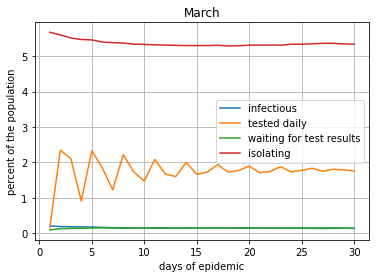

In [11]:
o_March = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

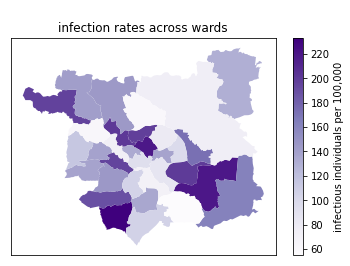

In [12]:
o_March.recorder.components[-1].map_incidence(end_date=True)

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

2021-05-16 16:20:29.908 INFO     50.0% of workplaces closed by lockdown, leaving 48884 open, of average Income Decile 4.89 (and st dev 3.14).
2021-05-16 16:20:30.143 INFO     0.0% of classrooms closed by lockdown, leaving 1679 open, of average Income Decile 4.78 (and st dev 3.09).
2021-05-16 16:20:30.186 INFO     Adding 361622 permanent contact groups
2021-05-16 16:20:30.583 INFO     Adding 158627 ephemeral contact pairs
2021-05-16 16:20:31.569 INFO     Adding 239655 contacts each within one of the 141192 buildings (contact density of 0.75)


In [14]:
from codit.population.population import seed_infection

residents = [p for p in pop.people if 'Chapel' in p.home.ward.name]
ca, = {p.home.ward.name for p in residents}
logging.info(f"Seeding 15 infections of the Indian Variant in {ca}")
seed_infection(15, residents, indian_variant)

2021-05-16 16:20:37.277 INFO     Seeding 15 infections in Chapel Allerton


In [15]:
for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

In [16]:
pop.clear_memory()

2021-05-16 16:21:37.554 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0013
2021-05-16 16:31:34.309 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0012
2021-05-16 16:31:35.718 INFO      Realized R0 of early infections is 1.03
2021-05-16 16:31:35.719 INFO      21.2 percent of the population was infected during the epidemic


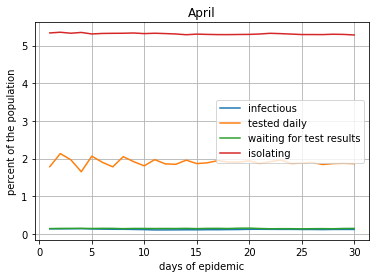

In [17]:
o_April = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

In [18]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

49 cases of the Indian Variant:
1 in Moortown
27 in Chapel Allerton
2 in Otley & Yeadon
1 in Middleton Park
2 in Harewood
2 in Gipton & Harehills
2 in Guiseley & Rawdon
2 in Alwoodley
1 in Temple Newsam
1 in Ardsley & Robin Hood
4 in Kippax & Methley
1 in Adel & Wharfedale
1 in Farnley & Wortley
2 in Armley


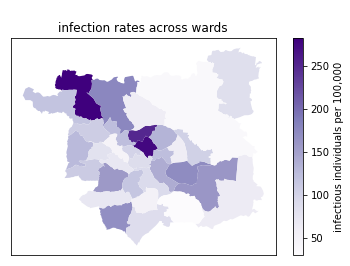

In [19]:
o_April.recorder.components[-1].map_incidence(end_date=True)

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [20]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 16:31:42.116 INFO     33.0% of workplaces closed by lockdown, leaving 62285 open, of average Income Decile 4.93 (and st dev 3.13).
2021-05-16 16:31:42.361 INFO     0.0% of classrooms closed by lockdown, leaving 1681 open, of average Income Decile 4.76 (and st dev 3.06).
2021-05-16 16:31:42.405 INFO     Adding 375025 permanent contact groups
2021-05-16 16:31:48.982 INFO     Adding 198284 ephemeral contact pairs
2021-05-16 16:31:49.896 INFO     Adding 239721 contacts each within one of the 141192 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [21]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with('AstraZeneca')

2021-05-16 16:32:55.121 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0012
2021-05-16 16:47:00.094 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0011
2021-05-16 16:47:01.314 INFO      Realized R0 of early infections is 0.95
2021-05-16 16:47:01.314 INFO      21.7 percent of the population was infected during the epidemic


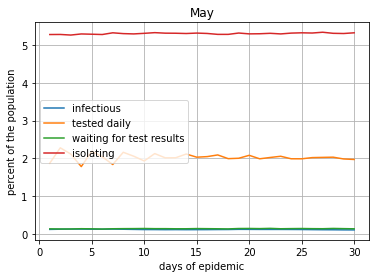

In [22]:
o_May = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")

In [23]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

42 cases of the Indian Variant:
6 in Little London & Woodhouse
3 in Weetwood
4 in Killingbeck & Seacroft
16 in Calverley & Farsley
1 in Harewood
1 in Rothwell
1 in Bramley & Stanningley
1 in Roundhay
7 in Gipton & Harehills
1 in Kippax & Methley
1 in Headingley & Hyde Park


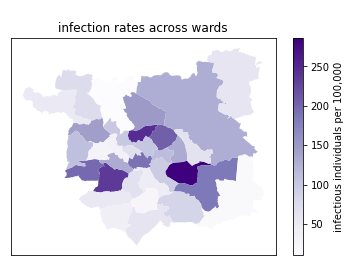

In [24]:
o_May.recorder.components[-1].map_incidence(end_date=True)